## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import Dropout
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization
def build_mlp(input_shape,L1_EXP,L2_EXP,IS_NOR, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=L1_EXP, l2=L2_EXP))(input_layer)            
            x = Dropout(drp_ratio)(x)
            if IS_NOR == True:
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=L1_EXP, l2=L2_EXP))(x)
            x = Dropout(drp_ratio)(x)
            if IS_NOR == True:
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

"""
建立實驗組合
"""
Dropout_EXP = [0, 0.4]
#LAYER_NEURONS = [128, 256, 512]
L1_EXP = [1e-2, 0.0]
L2_EXP = [1e-2, 0.0]
BatchSize = [512,256]
IsBatchNormal = [False,True]

In [11]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (l1_exp,l2_exp,drp_rate,_batch_size_item,is_b_normal) in enumerate(itertools.product(L1_EXP, L2_EXP,Dropout_EXP,BatchSize,IsBatchNormal)):
    print("Numbers of exp: %i, l1_exp: %.3f, l2_exp: %.3f, _batch_size_item: %.3f,drp_rate:%.3f,is_b_normal:%d " % (i, l1_exp,l2_exp,drp_rate,_batch_size_item,is_b_normal))
    model = build_mlp(input_shape=x_train.shape[1:],L1_EXP=l1_exp,L2_EXP=l2_exp,IS_NOR=is_b_normal, drp_ratio=drp_rate)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=_batch_size_item, 
              validation_data=(x_test, y_test), 
              verbose=0,
              shuffle=True)

    # Collect results
    exp_name_tag = ("exp-%s,l1:%s,l2:%s,_b:%s,d:%s,n:%s" % (i,str(L1_EXP), str(L2_EXP),str(Dropout_EXP),str(BatchSize),str(IsBatchNormal)))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, l1_exp: 0.010, l2_exp: 0.010, _batch_size_item: 0.000,drp_rate:512.000,is_b_normal:0 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________

W0722 17:38:04.637716  8204 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Numbers of exp: 4, l1_exp: 0.010, l2_exp: 0.010, _batch_size_item: 0.400,drp_rate:512.000,is_b_normal:0 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________

Numbers of exp: 9, l1_exp: 0.010, l2_exp: 0.000, _batch_size_item: 0.000,drp_rate:512.000,is_b_normal:1 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_32 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_____________________________________

Numbers of exp: 14, l1_exp: 0.010, l2_exp: 0.000, _batch_size_item: 0.400,drp_rate:256.000,is_b_normal:0 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_47 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_48 (Dropout)         (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____________________________________

Numbers of exp: 19, l1_exp: 0.000, l2_exp: 0.010, _batch_size_item: 0.000,drp_rate:256.000,is_b_normal:1 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
____________________________________

Numbers of exp: 24, l1_exp: 0.000, l2_exp: 0.000, _batch_size_item: 0.000,drp_rate:512.000,is_b_normal:0 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_77 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_78 (Dropout)         (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____________________________________

Numbers of exp: 29, l1_exp: 0.000, l2_exp: 0.000, _batch_size_item: 0.400,drp_rate:512.000,is_b_normal:1 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_92 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_93 (Dropout)         (None, 256)               0         
____________________________________

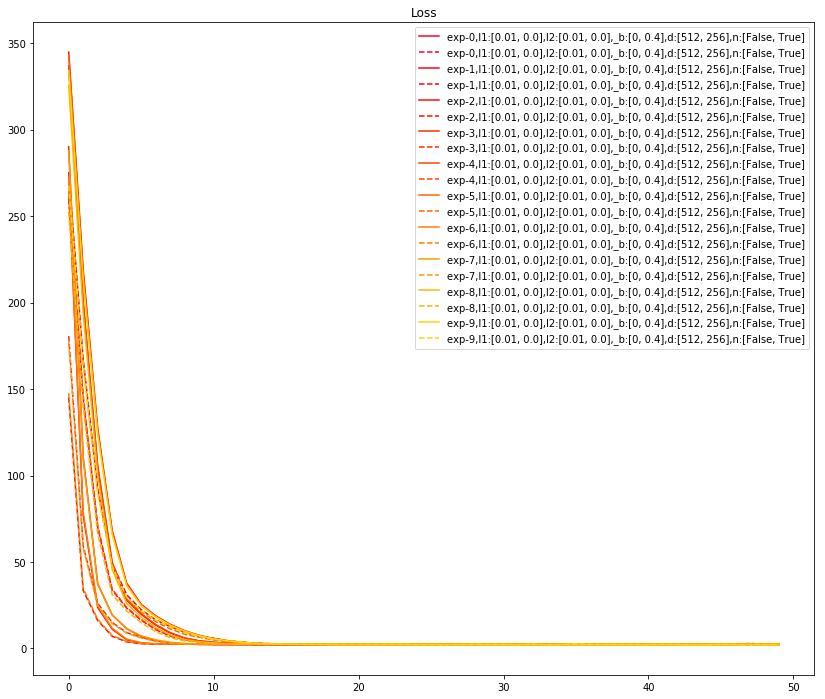

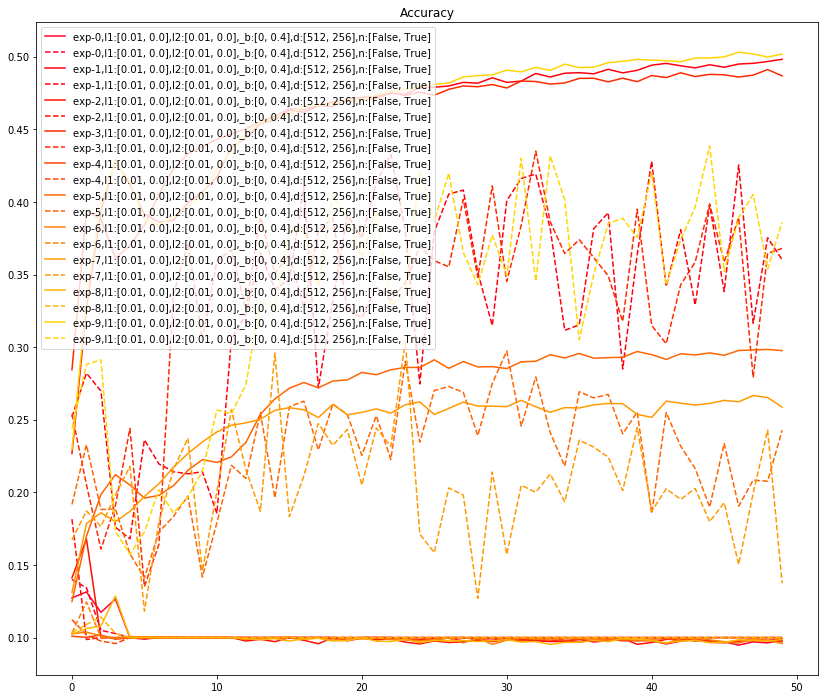

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 50

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i<10:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i<10:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

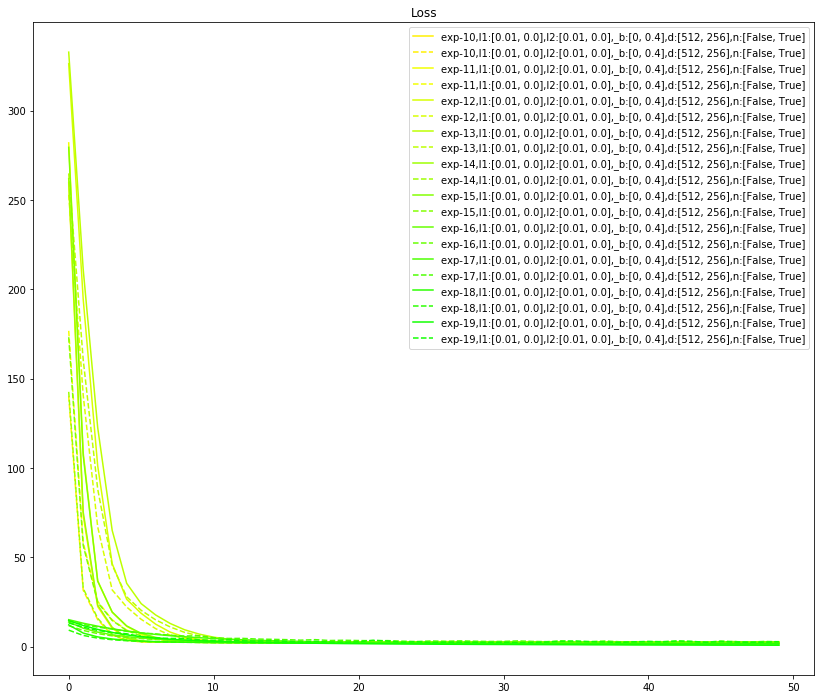

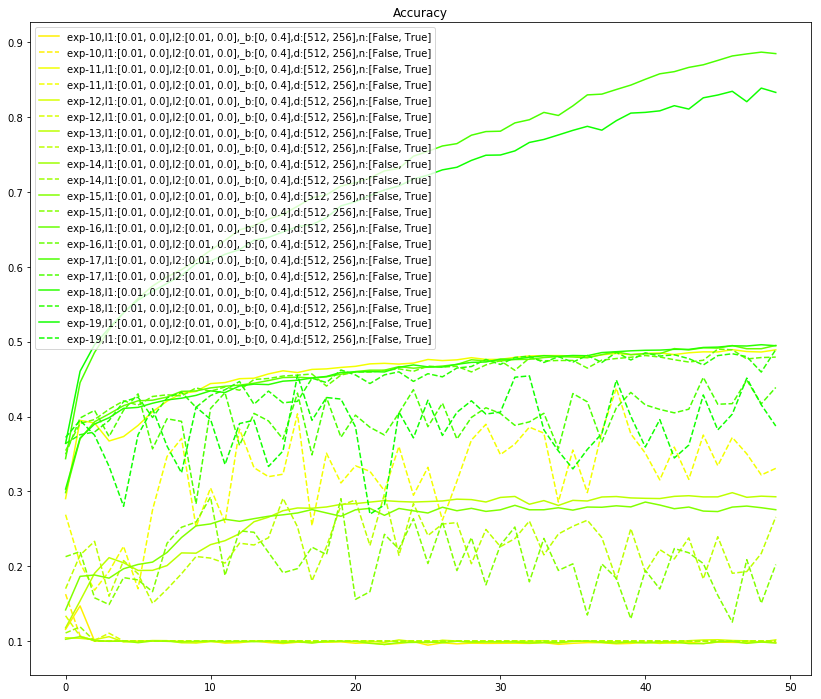

In [17]:
plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i>=10 and i<20:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i>=10 and i<20:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

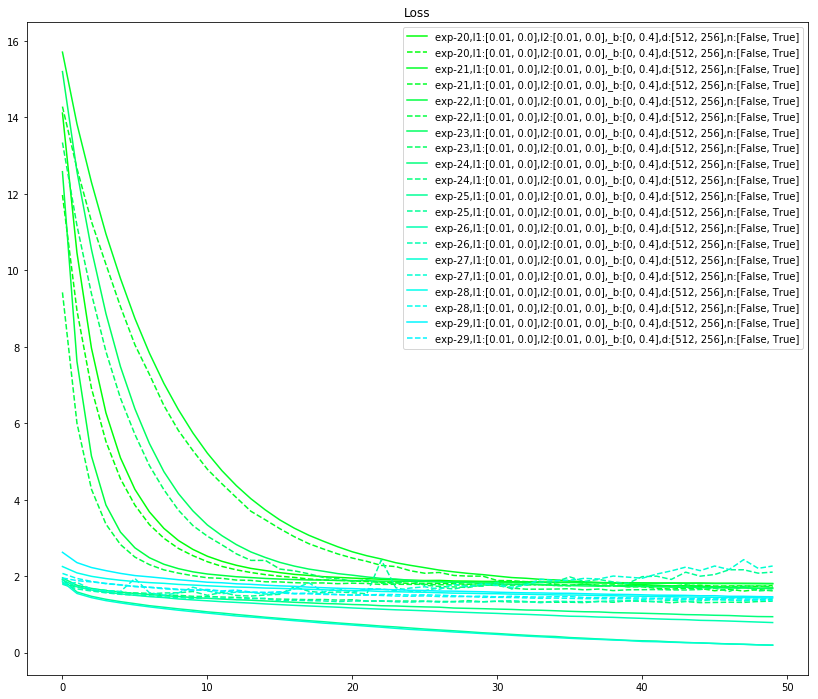

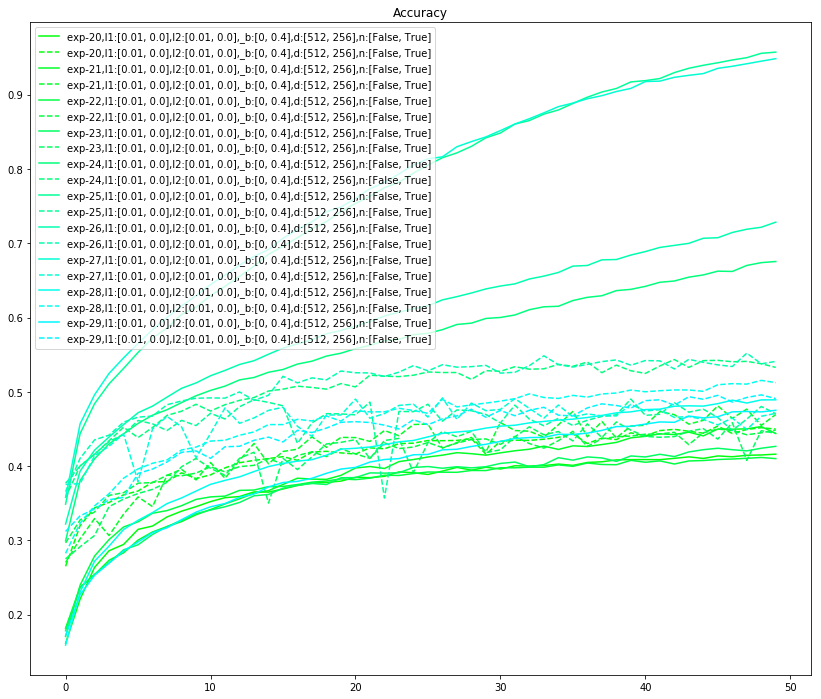

In [18]:
plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i>=20 and i<30:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i>=20 and i<30:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

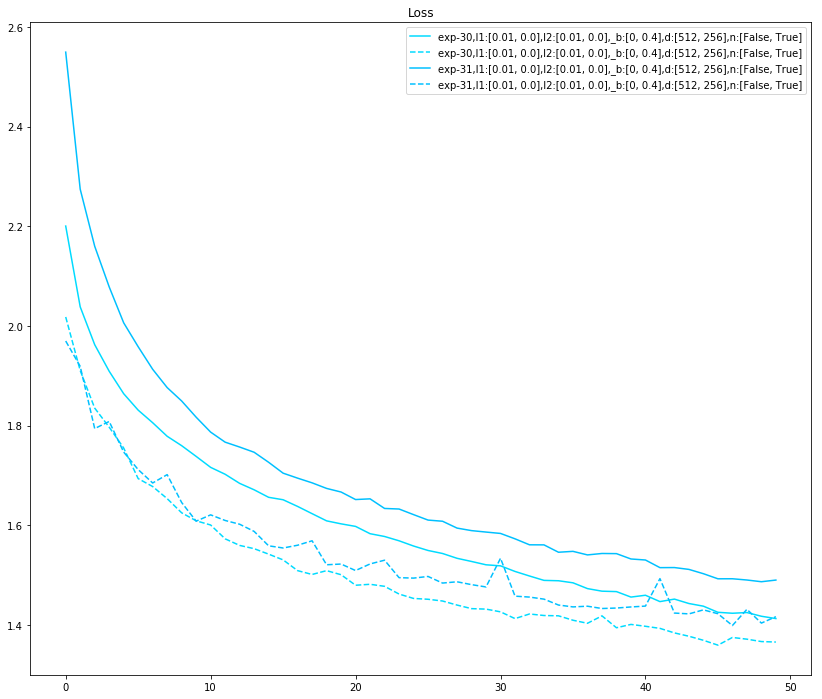

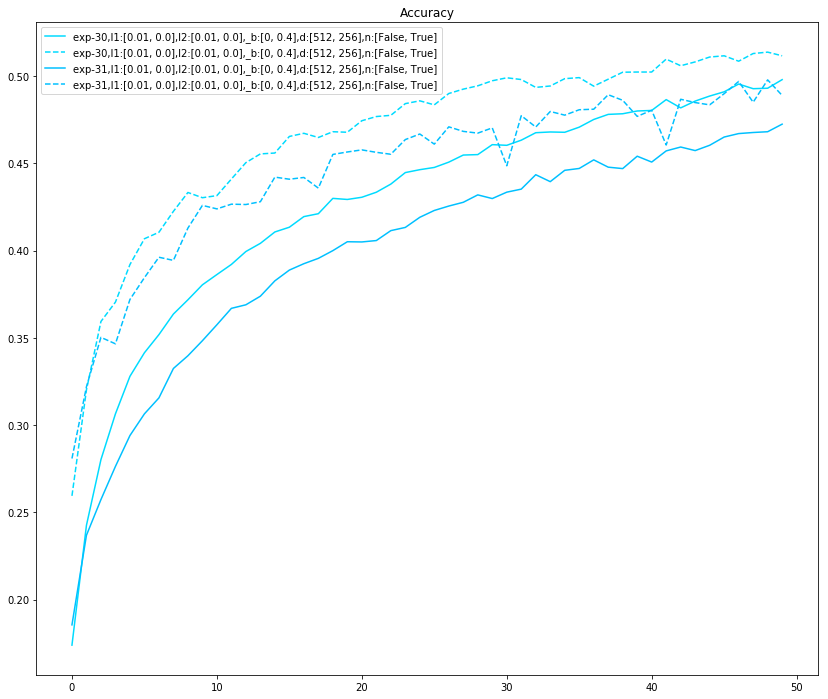

In [19]:
plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i>=30:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i>=30:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

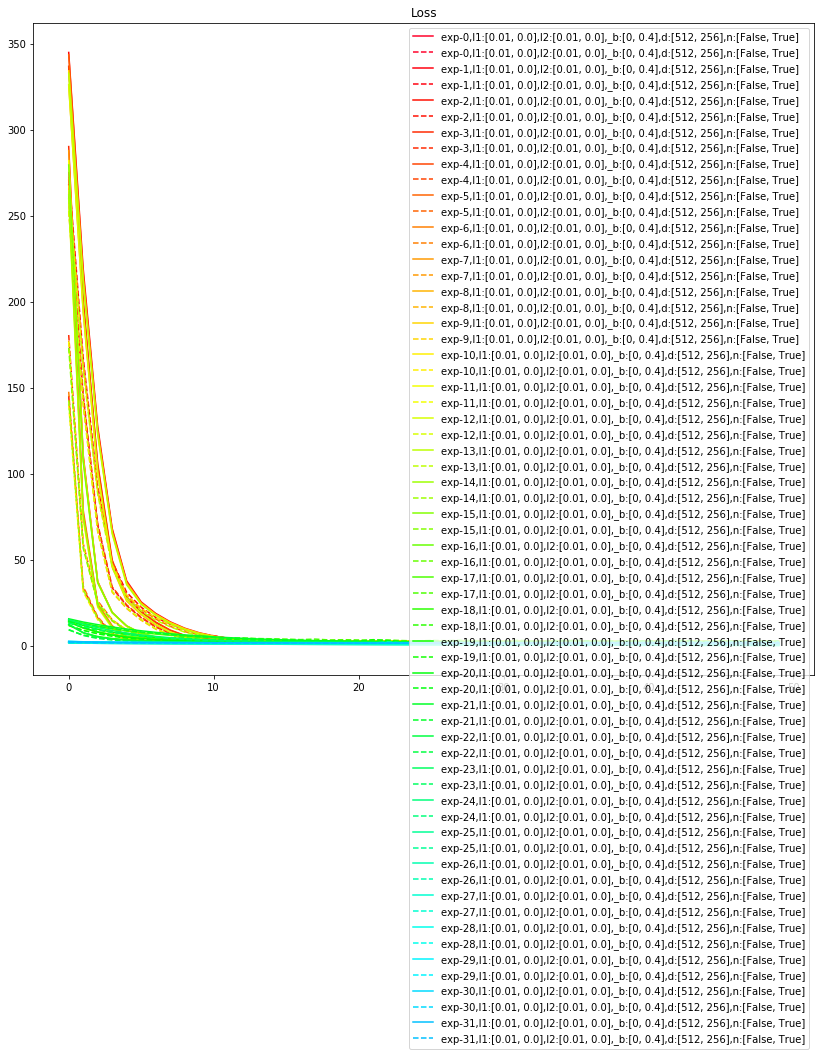

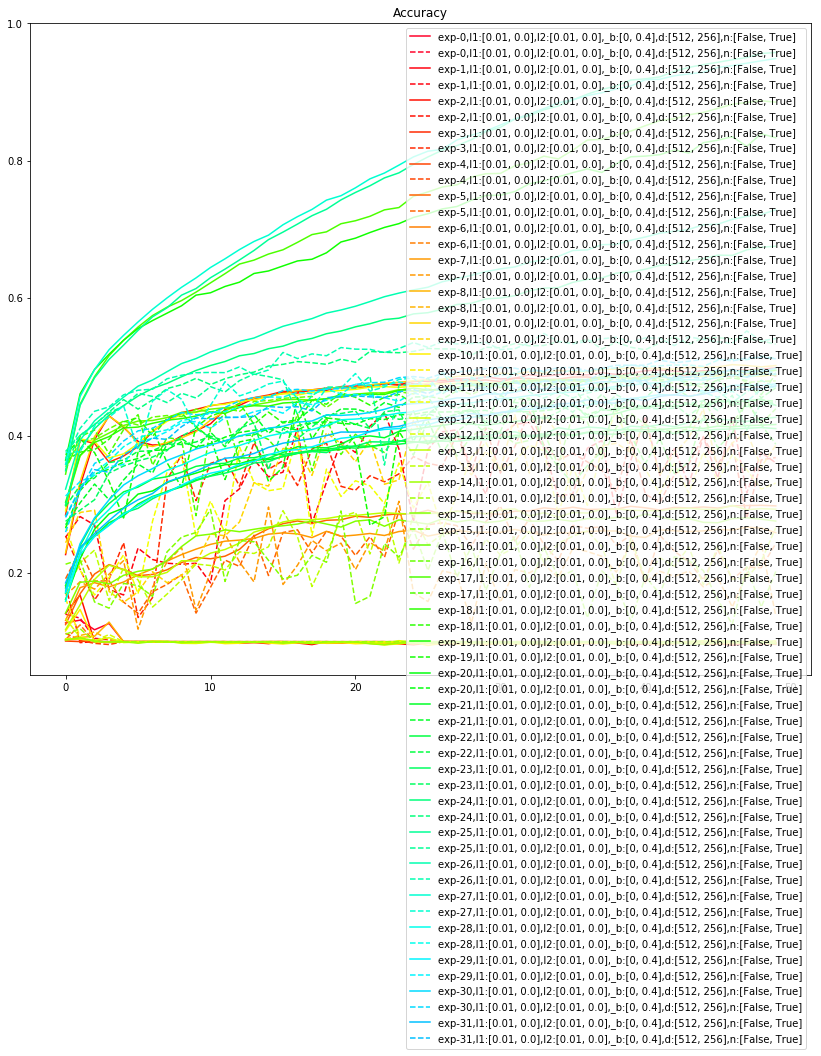

In [20]:
plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i>=0:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(14,12))
for i, cond in enumerate(results.keys()):
    if i>=0:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()